## Repères du notebook image_Transfer_Learning
    
   1. [fonctions à utiliser pour ce projet: pré-traitement et visualisation](#introduction)
   
   
   2. [Introduction: Chargement des données et observations](#df)
   

   3. [Pre-traitement et entrainement de différents modéles considérés](#p1)
   
       [première tentative exemple: benchmark model](#sub1-p1)
       
       [VGG16](#sub2-p1)
       
       [RESNET](#sub3-p1)
       
       [InV3](#sub4-p1)
   

   4. [Predictions: modèles transfer learning](#p2)
   
       [première tentative exemple: benchmark model](#sub1-p2)
       
       [VGG16](#sub2-p2)
       
       [RESNET](#sub3-p2)
       
       [InV3](#sub4-p2)
   
   
   
   5. [modèle pré-entrainé: extractioin de features et clustering](#p3)
   
       [Chargement des images et pré-traitement (redimension des images)](#sub1-p3)
       
       [Extraction de features avec modèle VGG16](#sub2-p3)
       
       [Clusters de features extraites des images](#sub3-p3)
   
   
   
   6. [Résultats et visualisation](#p4)

In [58]:
import numpy as np
import pandas as pd
import random
import os
import cv2
from IPython.display import Image
from PIL import Image as Image_PIL
import matplotlib.pyplot as plt
import seaborn as sns

#from keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

## 1. fonctions projet: pré-traitement et visualisation <a class="anchor" id="introduction"></a>

In [59]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    del shape
    return im

def get_files(path_list):
    '''Renvoie la liste des matrices d\'images à partir d'une liste de chemins'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2imread(image_path, 0)
        im = np.array(Image_PIL.open(image_path))
        liste_image.append(im)
        compteur +=1
    return liste_image

def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        #val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        #val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    #sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    #plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    #sns.lineplot(epochs, val_loss, label='Validation Loss')
    #plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

## 2. Introduction: Chargement, train-test split et observations des images<a class="anchor" id="df"></a>

In [60]:
%matplotlib inline
from os import listdir
path = "C:/Users/Adnene/Documents/Projet_6/Flipkart/Images"
list_photos = [file for file in listdir(path)]
print(len(list_photos))


1050


In [61]:
text_data =  pd.read_csv("Flipkart/flipkart_com-ecommerce_sample_1050.csv")
print(text_data.shape)

l_cat = []
for i in range(len(text_data)):
    cat = text_data['product_category_tree'][i].split('>>')[0][2:]
    l_cat.append(cat)

text_data['label'] = l_cat
l_cat = list(dict.fromkeys(l_cat))

print(l_cat)

image_data = text_data[['image', 'label']]

le = preprocessing.LabelEncoder()
image_data["enc_label"] = le.fit_transform(image_data["label"])
image_data

(1050, 15)
['Home Furnishing ', 'Baby Care ', 'Watches ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ', 'Beauty and Personal Care ', 'Computers ']


<ipython-input-61-a4cdcc986048>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data["enc_label"] = le.fit_transform(image_data["label"])


,image,label,enc_label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [62]:
image_data['image'] = image_data['image'].apply(lambda x: path+ '/' + str(x))

train, test = train_test_split(image_data, test_size = 0.25, random_state=42)

print("train set : ", train.shape)
print("test set : ", test.shape)

train set :  (787, 3)
test set :  (263, 3)


<ipython-input-62-08d8af429989>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data['image'] = image_data['image'].apply(lambda x: path+ '/' + str(x))


C:\Users\Adnene\anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


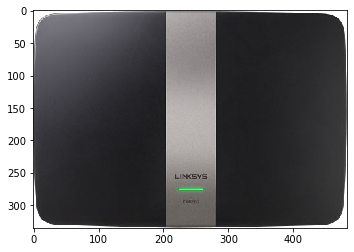

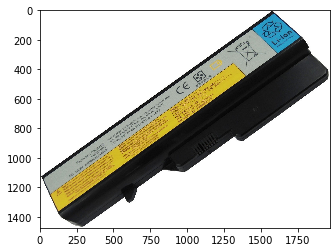

In [63]:
train_cnn = get_files(train.copy()['image'].tolist())
test_cnn = get_files(test.copy()['image'].tolist())

plt.imshow(train_cnn[2], interpolation='nearest')
plt.show()

plt.imshow(test_cnn[2], interpolation='nearest')
plt.show()

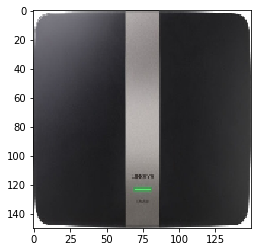

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [64]:
train_array_cnn = np.vstack([redim(img, 150, 150).reshape(1,150,150,3) for img in train_cnn])
test_array_cnn = np.vstack([redim(img, 150, 150).reshape(1,150,150,3) for img in test_cnn])

train_array_cat = train['label']
test_array_cat = test['label']

plt.imshow(train_array_cnn[2], interpolation='nearest')
plt.show()

train_array_cnn[2]

# 3. Pre-traitement et entrainement de différents modéles considérés<a class="anchor" id="p1"></a>

## première tentative exemple: benchmark model<a class="anchor" id="sub1-p1"></a>

In [65]:
ohe = OneHotEncoder(handle_unknown='ignore')
train_array_cats = ohe.fit_transform(np.array(train_array_cat).reshape(-1,1)).todense()
test_array_cats = ohe.transform(np.array(test_array_cat).reshape(-1,1)).todense()

In [66]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 10
vgg_epoch = 10
resnet_epoch = 10
inception_epoch = 10

In [67]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(7,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

In [68]:
filepath = "models/bench_mark_-model-{epoch:02d}-{acc:.6f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_array_cnn, train_array_cats, epochs=benchmark_epoch, verbose=1 ,callbacks=[reduce_lr,early_stopping,checkpoint])



Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 167.8033 - acc: 0.1487
Epoch 1: acc improved from -inf to 0.14867, saving model to models\bench_mark_-model-01-0.148666.hdf5
25/25 [==============================] - 28s 1s/step - loss: 167.8033 - acc: 0.1487 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.9186 - acc: 0.1741
Epoch 2: acc improved from 0.14867 to 0.17408, saving model to models\bench_mark_-model-02-0.174079.hdf5
25/25 [==============================] - 30s 1s/step - loss: 1.9186 - acc: 0.1741 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.9259 - acc: 0.1893
Epoch 3: acc improved from 0.17408 to 0.18933, saving model to models\bench_mark_-model-03-0.189327.hdf5
25/25 [==============================] - 30s 1s/step - loss: 1.9259 - acc: 0.1893 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 1.9110 - acc: 0.1715
Epoch 4: acc did not improve from 0.18933
2

INFO:tensorflow:Assets written to: models/weighs_benchmark_model.weights\assets


C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


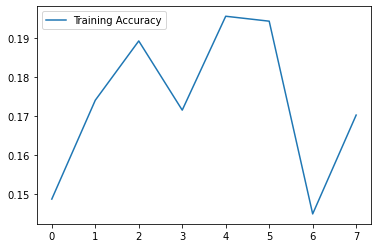

<Figure size 432x288 with 0 Axes>

C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


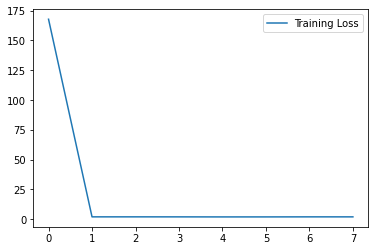

<Figure size 432x288 with 0 Axes>

In [69]:
benchmark_model.save('models/weighs_benchmark_model.weights')
do_history_stuff(history, 'benchmark_model')

## VGG16<a class="anchor" id="sub2-p1"></a>

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 5.5232 - acc: 0.5083
Epoch 1: acc improved from -inf to 0.50826, saving model to models\vgg_16_-saved-model-01-acc-0.508259.hdf5
25/25 [==============================] - 26s 1s/step - loss: 5.5232 - acc: 0.5083
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2947 - acc: 0.8094
Epoch 2: acc improved from 0.50826 to 0.80940, saving model to models\vgg_16_-saved-model-02-acc-0.809403.hdf5
25/25 [==============================] - 27s 1s/step - loss: 1.2947 - acc: 0.8094
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.3477 - acc: 0.9212
Epoch 3: acc improved from 0.80940 to 0.92122, saving model to models\vgg_16_-saved-model-03-acc-0.921220.hdf5
25/25 [==============================] - 26s 1s/step - loss: 0.3477 - acc: 0.9212
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.0848 - acc: 0.9759
Epoch 4: acc improved from 0.92122 to 0.97586, saving model to model

C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


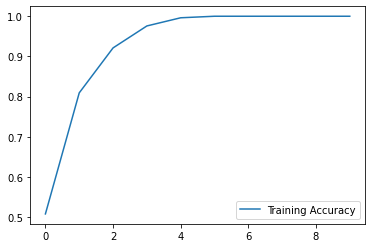

<Figure size 432x288 with 0 Axes>

C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


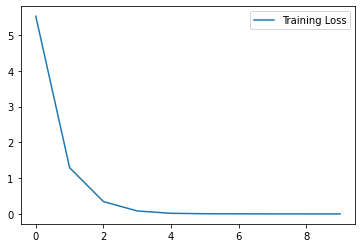

<Figure size 432x288 with 0 Axes>

In [70]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(7, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'models/vgg_16_'+'-saved-model-{epoch:02d}-acc-{acc:.6f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_array_cnn, train_array_cats, epochs=benchmark_epoch,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

## RESNET<a class="anchor" id="sub3-p1"></a>

Epoch 1/10


C:\Users\Adnene\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


25/25 [==============================] - ETA: 0s - loss: 2.1819 - acc: 0.5489
Epoch 1: acc improved from -inf to 0.54892, saving model to models\resnet50-saved-model-01-acc-0.548920.hdf5
25/25 [==============================] - 68s 3s/step - loss: 2.1819 - acc: 0.5489 - lr: 0.0100
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.3945 - acc: 0.8755
Epoch 2: acc improved from 0.54892 to 0.87548, saving model to models\resnet50-saved-model-02-acc-0.875476.hdf5
25/25 [==============================] - 65s 3s/step - loss: 0.3945 - acc: 0.8755 - lr: 0.0100
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.0686 - acc: 0.9797
Epoch 3: acc improved from 0.87548 to 0.97967, saving model to models\resnet50-saved-model-03-acc-0.979670.hdf5
25/25 [==============================] - 65s 3s/step - loss: 0.0686 - acc: 0.9797 - lr: 0.0100
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.0266 - acc: 0.9962
Epoch 4: acc improved from 0.97967 to

C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


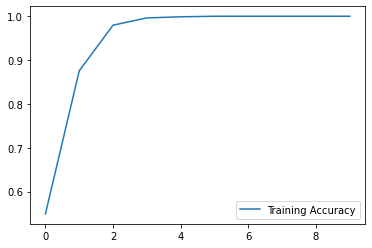

<Figure size 432x288 with 0 Axes>

C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


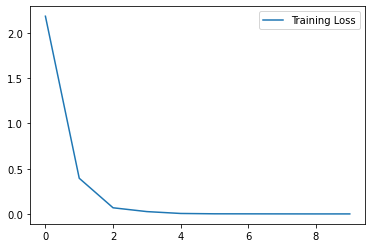

<Figure size 432x288 with 0 Axes>

In [71]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=7)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(7,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'models/resnet50'+'-saved-model-{epoch:02d}-acc-{acc:.6f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_array_cnn, train_array_cats, epochs=benchmark_epoch, callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')

## InV3<a class="anchor" id="sub4-p1"></a>

Epoch 1/10


C:\Users\Adnene\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


25/25 [==============================] - ETA: 0s - loss: 2.2445 - accuracy: 0.2046
Epoch 1: accuracy improved from -inf to 0.20457, saving model to models\inceptionv3_-saved-model-01-loss-2.244469.hdf5
25/25 [==============================] - 16s 527ms/step - loss: 2.2445 - accuracy: 0.2046
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.7823 - accuracy: 0.3227
Epoch 2: accuracy improved from 0.20457 to 0.32274, saving model to models\inceptionv3_-saved-model-02-loss-1.782311.hdf5
25/25 [==============================] - 13s 536ms/step - loss: 1.7823 - accuracy: 0.3227
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.6069 - accuracy: 0.3736
Epoch 3: accuracy improved from 0.32274 to 0.37357, saving model to models\inceptionv3_-saved-model-03-loss-1.606937.hdf5
25/25 [==============================] - 13s 536ms/step - loss: 1.6069 - accuracy: 0.3736
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 0.5006
Ep

C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


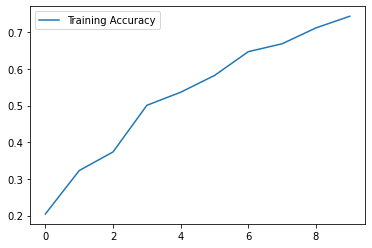

<Figure size 432x288 with 0 Axes>

C:\Users\Adnene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


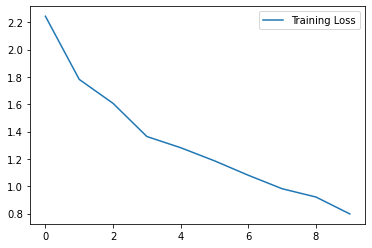

<Figure size 432x288 with 0 Axes>

In [72]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(7, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'models/inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.6f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_array_cnn, train_array_cats, epochs=benchmark_epoch, callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)

In [73]:
vgg_best_model = vgg16_final_model 
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model 

# 4. Predictions CNN - transfer learning<a class="anchor" id="p2"></a>

## Benchmark<a class="anchor" id="sub1-p2"></a>

In [74]:
bench_test_output = benchmark_model.predict(test_array_cnn)

In [75]:
labels_test_bench = np.argmax(bench_test_output, 1)
true_labels_test = np.squeeze(np.asarray(test_array_cats.argmax(1)))

metrics.accuracy_score(true_labels_test, labels_test_bench)

0.10266159695817491

## VGG<a class="anchor" id="sub2-p2"></a>

In [76]:
vgg_pred = vgg_best_model.predict(test_array_cnn)
vgg_pred

array([[6.6602892e-13, 3.2353675e-08, 9.9999988e-01, ..., 3.2194631e-14,
        6.8330280e-08, 3.7387167e-08],
       [2.2163893e-17, 9.1050868e-05, 6.3905645e-07, ..., 9.6402015e-09,
        9.9976462e-01, 1.4377703e-04],
       [9.6360463e-01, 1.4909526e-05, 1.9742385e-02, ..., 3.7024631e-05,
        2.9367782e-06, 3.4726781e-06],
       ...,
       [1.0000000e+00, 4.2826476e-10, 7.4798549e-25, ..., 5.8991694e-21,
        7.0590631e-13, 9.7194252e-14],
       [3.3318376e-18, 4.9302881e-16, 4.5355466e-19, ..., 1.5033031e-16,
        1.0332769e-20, 1.0000000e+00],
       [1.7028587e-19, 3.3421760e-17, 4.0846131e-14, ..., 1.2375536e-19,
        3.0439349e-16, 1.0000000e+00]], dtype=float32)

In [77]:
test_array_cats

matrix([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [78]:
labels_test_vgg = np.argmax(vgg_pred, 1)
true_labels_test = np.squeeze(np.asarray(test_array_cats.argmax(1)))
true_labels_test

array([2, 5, 2, 1, 6, 0, 3, 2, 4, 4, 6, 0, 5, 1, 2, 2, 0, 2, 4, 4, 5, 2,
       0, 2, 6, 1, 3, 5, 1, 5, 5, 2, 2, 6, 3, 4, 6, 3, 3, 2, 4, 1, 5, 4,
       1, 5, 5, 2, 0, 4, 5, 3, 5, 4, 2, 0, 1, 5, 2, 4, 4, 0, 6, 5, 6, 4,
       0, 3, 4, 6, 0, 2, 2, 2, 6, 2, 4, 3, 2, 4, 4, 4, 2, 5, 2, 6, 4, 3,
       3, 3, 4, 4, 5, 3, 6, 2, 0, 6, 3, 0, 4, 6, 3, 4, 2, 6, 1, 5, 4, 2,
       5, 4, 4, 0, 0, 0, 2, 6, 6, 2, 2, 2, 3, 4, 5, 3, 1, 3, 0, 0, 5, 1,
       0, 3, 0, 5, 3, 1, 5, 2, 5, 0, 3, 4, 4, 6, 6, 1, 3, 1, 6, 1, 6, 3,
       2, 4, 6, 1, 3, 6, 6, 6, 0, 2, 3, 6, 6, 2, 6, 2, 6, 1, 4, 6, 0, 6,
       3, 3, 4, 3, 0, 5, 4, 3, 0, 1, 0, 6, 2, 4, 1, 6, 5, 4, 5, 2, 1, 5,
       2, 2, 1, 0, 4, 2, 1, 3, 6, 0, 0, 3, 6, 3, 2, 2, 4, 1, 0, 4, 3, 3,
       4, 0, 1, 4, 2, 3, 4, 0, 2, 1, 2, 2, 1, 2, 5, 4, 0, 6, 1, 4, 4, 4,
       4, 0, 3, 2, 3, 3, 0, 5, 0, 6, 5, 0, 5, 0, 5, 3, 1, 0, 0, 6, 6],
      dtype=int64)

In [79]:
labels_test_vgg

array([2, 5, 0, 1, 6, 0, 1, 2, 0, 4, 6, 4, 5, 1, 0, 2, 0, 2, 0, 4, 5, 1,
       0, 1, 6, 1, 1, 5, 1, 5, 5, 2, 2, 6, 0, 4, 6, 3, 0, 2, 0, 4, 5, 4,
       6, 5, 2, 1, 3, 4, 5, 3, 5, 0, 2, 0, 1, 6, 0, 4, 0, 3, 3, 5, 6, 3,
       2, 3, 4, 6, 4, 2, 2, 0, 6, 2, 4, 1, 2, 4, 3, 4, 2, 0, 2, 6, 4, 0,
       3, 0, 0, 4, 5, 3, 6, 2, 0, 6, 3, 0, 4, 6, 0, 4, 2, 6, 1, 0, 4, 2,
       2, 4, 4, 0, 4, 1, 2, 6, 6, 0, 2, 2, 2, 4, 5, 5, 1, 0, 4, 4, 5, 4,
       3, 3, 2, 5, 3, 1, 5, 2, 5, 0, 1, 0, 4, 6, 6, 1, 4, 3, 6, 3, 6, 3,
       2, 4, 6, 1, 6, 6, 6, 6, 4, 2, 3, 6, 6, 2, 6, 2, 6, 1, 4, 2, 0, 6,
       3, 5, 4, 5, 3, 5, 4, 5, 0, 1, 5, 6, 2, 4, 1, 6, 1, 4, 5, 2, 1, 3,
       2, 2, 1, 0, 4, 2, 1, 6, 6, 3, 5, 3, 6, 2, 2, 2, 4, 1, 4, 0, 3, 3,
       0, 3, 3, 4, 2, 3, 4, 4, 2, 1, 2, 2, 1, 2, 5, 4, 4, 6, 1, 4, 0, 0,
       0, 0, 5, 1, 5, 3, 4, 2, 0, 6, 5, 0, 5, 0, 5, 3, 1, 0, 0, 6, 6],
      dtype=int64)

In [80]:
metrics.accuracy_score(true_labels_test, labels_test_vgg)

0.6920152091254753

In [81]:
metrics.adjusted_rand_score(true_labels_test, labels_test_vgg)

0.46670924030604616

## Resnet<a class="anchor" id="sub3-p2"></a>

In [82]:
vgg_best_model = vgg16_final_model 
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model 



res_pred = resnet_best_model.predict(test_array_cnn)
res_pred

labels_test_res = np.argmax(res_pred, 1)
true_labels_test = np.squeeze(np.asarray(test_array_cats.argmax(1)))

print(metrics.accuracy_score(true_labels_test, labels_test_res))
metrics.adjusted_rand_score(true_labels_test, labels_test_res)

0.8288973384030418


0.6479588755120147

## inV3<a class="anchor" id="sub4-p2"></a>

In [83]:
in_pred = inception_best_model.predict(test_array_cnn)

labels_test_in = np.argmax(in_pred, 1)
true_labels_test = np.squeeze(np.asarray(test_array_cats.argmax(1)))

metrics.accuracy_score(true_labels_test, labels_test_in)

0.4296577946768061

In [84]:
metrics.adjusted_rand_score(true_labels_test, labels_test_in)

0.1523544760769347

# 5. modèle pré-entrainé: extractioin de features et clustering<a class="anchor" id="p3"></a>

## Chargement des images et pré-traitement (redimension des images)<a class="anchor" id="sub1-p3"></a>

In [85]:
image_cnn = get_files(image_data.copy()['image'].tolist())
image_array_cnn = np.vstack([redim(img, 150, 150).reshape(1,150,150,3) for img in image_cnn])

C:\Users\Adnene\anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [86]:
image_cnn

[array([[[192, 184, 173],
         [192, 184, 173],
         [193, 185, 174],
         ...,
         [174, 165, 156],
         [174, 165, 156],
         [174, 165, 156]],
 
        [[192, 184, 173],
         [193, 185, 174],
         [193, 185, 174],
         ...,
         [174, 165, 156],
         [174, 165, 156],
         [174, 165, 156]],
 
        [[192, 186, 174],
         [193, 187, 175],
         [193, 187, 175],
         ...,
         [175, 166, 157],
         [174, 165, 156],
         [174, 165, 156]],
 
        ...,
 
        [[209, 174, 136],
         [209, 174, 136],
         [209, 174, 136],
         ...,
         [130,  94,  96],
         [134,  99,  97],
         [139, 104, 100]],
 
        [[210, 175, 137],
         [210, 175, 137],
         [210, 175, 137],
         ...,
         [140, 105, 103],
         [143, 108, 102],
         [147, 113, 104]],
 
        [[210, 175, 137],
         [210, 175, 137],
         [210, 175, 137],
         ...,
         [149, 114, 110],
  

## Extraction de features avec modèle VGG16<a class="anchor" id="sub2-p3"></a>

In [87]:
# pre-trained model as a classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump

# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

feature_list = []
image_array_cnn = np.vstack([redim(img, 224, 224).reshape(1,224,224,3) for img in image_cnn])
c = 0
# load and preprocess image from file
for image in image_array_cnn:
    c+=1
    #image_array_cnn = np.vstack([redim(img, 224, 224).reshape(1,224,224,3)
    #image = image.reshape(None,224,224,3)
    # convert the image pixels to a numpy array
    #image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    features = model.predict(image)
    feature_list.append(features)
    print("feature shape of image {}".format(c), features.shape)
    # save to file
    dump(features, open('features_vgg\{}.pkl'.format(c), 'wb'))

feature shape of image 1 (1, 4096)
feature shape of image 2 (1, 4096)
feature shape of image 3 (1, 4096)
feature shape of image 4 (1, 4096)
feature shape of image 5 (1, 4096)
feature shape of image 6 (1, 4096)
feature shape of image 7 (1, 4096)
feature shape of image 8 (1, 4096)
feature shape of image 9 (1, 4096)
feature shape of image 10 (1, 4096)
feature shape of image 11 (1, 4096)
feature shape of image 12 (1, 4096)
feature shape of image 13 (1, 4096)
feature shape of image 14 (1, 4096)
feature shape of image 15 (1, 4096)
feature shape of image 16 (1, 4096)
feature shape of image 17 (1, 4096)
feature shape of image 18 (1, 4096)
feature shape of image 19 (1, 4096)
feature shape of image 20 (1, 4096)
feature shape of image 21 (1, 4096)
feature shape of image 22 (1, 4096)
feature shape of image 23 (1, 4096)
feature shape of image 24 (1, 4096)
feature shape of image 25 (1, 4096)
feature shape of image 26 (1, 4096)
feature shape of image 27 (1, 4096)
feature shape of image 28 (1, 4096)
f

feature shape of image 227 (1, 4096)
feature shape of image 228 (1, 4096)
feature shape of image 229 (1, 4096)
feature shape of image 230 (1, 4096)
feature shape of image 231 (1, 4096)
feature shape of image 232 (1, 4096)
feature shape of image 233 (1, 4096)
feature shape of image 234 (1, 4096)
feature shape of image 235 (1, 4096)
feature shape of image 236 (1, 4096)
feature shape of image 237 (1, 4096)
feature shape of image 238 (1, 4096)
feature shape of image 239 (1, 4096)
feature shape of image 240 (1, 4096)
feature shape of image 241 (1, 4096)
feature shape of image 242 (1, 4096)
feature shape of image 243 (1, 4096)
feature shape of image 244 (1, 4096)
feature shape of image 245 (1, 4096)
feature shape of image 246 (1, 4096)
feature shape of image 247 (1, 4096)
feature shape of image 248 (1, 4096)
feature shape of image 249 (1, 4096)
feature shape of image 250 (1, 4096)
feature shape of image 251 (1, 4096)
feature shape of image 252 (1, 4096)
feature shape of image 253 (1, 4096)
f

feature shape of image 449 (1, 4096)
feature shape of image 450 (1, 4096)
feature shape of image 451 (1, 4096)
feature shape of image 452 (1, 4096)
feature shape of image 453 (1, 4096)
feature shape of image 454 (1, 4096)
feature shape of image 455 (1, 4096)
feature shape of image 456 (1, 4096)
feature shape of image 457 (1, 4096)
feature shape of image 458 (1, 4096)
feature shape of image 459 (1, 4096)
feature shape of image 460 (1, 4096)
feature shape of image 461 (1, 4096)
feature shape of image 462 (1, 4096)
feature shape of image 463 (1, 4096)
feature shape of image 464 (1, 4096)
feature shape of image 465 (1, 4096)
feature shape of image 466 (1, 4096)
feature shape of image 467 (1, 4096)
feature shape of image 468 (1, 4096)
feature shape of image 469 (1, 4096)
feature shape of image 470 (1, 4096)
feature shape of image 471 (1, 4096)
feature shape of image 472 (1, 4096)
feature shape of image 473 (1, 4096)
feature shape of image 474 (1, 4096)
feature shape of image 475 (1, 4096)
f

feature shape of image 671 (1, 4096)
feature shape of image 672 (1, 4096)
feature shape of image 673 (1, 4096)
feature shape of image 674 (1, 4096)
feature shape of image 675 (1, 4096)
feature shape of image 676 (1, 4096)
feature shape of image 677 (1, 4096)
feature shape of image 678 (1, 4096)
feature shape of image 679 (1, 4096)
feature shape of image 680 (1, 4096)
feature shape of image 681 (1, 4096)
feature shape of image 682 (1, 4096)
feature shape of image 683 (1, 4096)
feature shape of image 684 (1, 4096)
feature shape of image 685 (1, 4096)
feature shape of image 686 (1, 4096)
feature shape of image 687 (1, 4096)
feature shape of image 688 (1, 4096)
feature shape of image 689 (1, 4096)
feature shape of image 690 (1, 4096)
feature shape of image 691 (1, 4096)
feature shape of image 692 (1, 4096)
feature shape of image 693 (1, 4096)
feature shape of image 694 (1, 4096)
feature shape of image 695 (1, 4096)
feature shape of image 696 (1, 4096)
feature shape of image 697 (1, 4096)
f

feature shape of image 893 (1, 4096)
feature shape of image 894 (1, 4096)
feature shape of image 895 (1, 4096)
feature shape of image 896 (1, 4096)
feature shape of image 897 (1, 4096)
feature shape of image 898 (1, 4096)
feature shape of image 899 (1, 4096)
feature shape of image 900 (1, 4096)
feature shape of image 901 (1, 4096)
feature shape of image 902 (1, 4096)
feature shape of image 903 (1, 4096)
feature shape of image 904 (1, 4096)
feature shape of image 905 (1, 4096)
feature shape of image 906 (1, 4096)
feature shape of image 907 (1, 4096)
feature shape of image 908 (1, 4096)
feature shape of image 909 (1, 4096)
feature shape of image 910 (1, 4096)
feature shape of image 911 (1, 4096)
feature shape of image 912 (1, 4096)
feature shape of image 913 (1, 4096)
feature shape of image 914 (1, 4096)
feature shape of image 915 (1, 4096)
feature shape of image 916 (1, 4096)
feature shape of image 917 (1, 4096)
feature shape of image 918 (1, 4096)
feature shape of image 919 (1, 4096)
f

In [88]:
len(feature_list)

1050

In [89]:
image_cnn

[array([[[192, 184, 173],
         [192, 184, 173],
         [193, 185, 174],
         ...,
         [174, 165, 156],
         [174, 165, 156],
         [174, 165, 156]],
 
        [[192, 184, 173],
         [193, 185, 174],
         [193, 185, 174],
         ...,
         [174, 165, 156],
         [174, 165, 156],
         [174, 165, 156]],
 
        [[192, 186, 174],
         [193, 187, 175],
         [193, 187, 175],
         ...,
         [175, 166, 157],
         [174, 165, 156],
         [174, 165, 156]],
 
        ...,
 
        [[209, 174, 136],
         [209, 174, 136],
         [209, 174, 136],
         ...,
         [130,  94,  96],
         [134,  99,  97],
         [139, 104, 100]],
 
        [[210, 175, 137],
         [210, 175, 137],
         [210, 175, 137],
         ...,
         [140, 105, 103],
         [143, 108, 102],
         [147, 113, 104]],
 
        [[210, 175, 137],
         [210, 175, 137],
         [210, 175, 137],
         ...,
         [149, 114, 110],
  

In [90]:
image_data

,image,label,enc_label
0,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Home Furnishing,4
1,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0
2,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0
3,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Home Furnishing,4
4,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Home Furnishing,4
...,...,...,...
1045,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0
1046,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0
1047,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0
1048,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0


In [91]:
image_data["features"] = feature_list

#image_data["features"] = [item for sublist in image_data["features"] for item in sublist]
image_data

<ipython-input-91-1b61e92eb1e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data["features"] = feature_list


,image,label,enc_label,features
0,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Home Furnishing,4,"[[3.453992, 0.72560954, 0.0, 1.2786673, 2.3333..."
1,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0,"[[0.0, 0.0, 0.0, 1.3818657, 0.0, 0.0, 0.0, 0.0..."
2,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0,"[[0.0, 0.0, 0.0, 4.428378, 0.0, 0.0, 0.0, 0.0,..."
3,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Home Furnishing,4,"[[0.0, 0.35566407, 0.0, 2.143285, 0.0, 0.04761..."
4,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Home Furnishing,4,"[[2.914065, 0.19636533, 0.0, 0.0, 1.0536327, 0..."
...,...,...,...,...
1045,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0,"[[2.4468365, 2.4009097, 0.0, 1.7436501, 2.9005..."
1046,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0,"[[1.4097811, 0.14685571, 0.3219393, 0.0, 2.192..."
1047,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0,"[[2.2781157, 2.3828912, 2.547882, 1.0232712, 0..."
1048,C:/Users/Adnene/Documents/Projet_6/Flipkart/Im...,Baby Care,0,"[[0.074376404, 0.0, 0.0, 0.0, 0.0, 0.18545602,..."


In [92]:
feature_list[4].shape

(1, 4096)

In [93]:
image_data["features"][4].shape

(1, 4096)

In [94]:
TL_features_by_img = np.asarray(image_data["features"])
TL_features_all = np.concatenate(TL_features_by_img, axis=0)

print()
print("Nombre de features : ", TL_features_all.shape)
TL_features_by_img.shape


Nombre de features :  (1050, 4096)


(1050,)

## Clusters de features extraites des images<a class="anchor" id="sub3-p3"></a>

In [95]:
from sklearn import cluster, metrics
import time

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(TL_features_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(TL_features_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

C:\Users\Adnene\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Nombre de clusters estimés :  32
Création de 32 clusters de descripteurs ...
temps de traitement kmeans :             0.72 secondes


In [96]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", TL_features_all.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(TL_features_all)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 800)


In [97]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = image_data['label']
print(df_tsne.shape)

C:\Users\Adnene\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [98]:
df_tsne

,tsne1,tsne2,class
0,17.581627,25.530781,Home Furnishing
1,27.648590,12.644119,Baby Care
2,28.623892,5.015467,Baby Care
3,27.134087,20.915512,Home Furnishing
4,28.918095,25.794453,Home Furnishing
...,...,...,...
1045,17.959414,24.376200,Baby Care
1046,6.310002,-0.961088,Baby Care
1047,10.443151,0.260570,Baby Care
1048,6.176637,-0.646720,Baby Care


# Resultats et visualisation<a class="anchor" id="p4"></a>

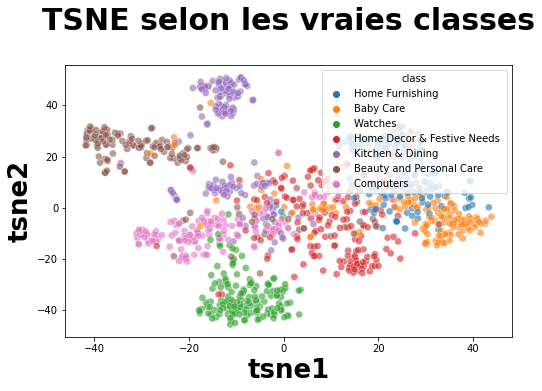

In [99]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
#plt.legend(prop={'size': 14}) 

plt.show()


In [100]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


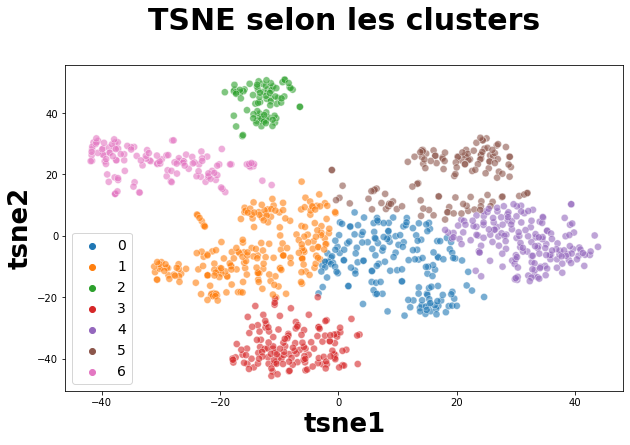

ARI :  0.4815981572040419


In [101]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = image_data["enc_label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [102]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    174
1    227
2     80
3    143
4    171
5    129
6    126
Name: class, dtype: int64

In [103]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 17   8   1   0 106  15   3]
 [ 13  12   1   1   3   3 117]
 [ 25 120   0   0   1   3   1]
 [103  16   0   4   6  19   2]
 [  5   1   0   0  55  89   0]
 [ 10  59  78   0   0   0   3]
 [  1  11   0 138   0   0   0]]


In [104]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6, 5, 4, 3, 2, 1, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6, 5, 4, 3, 2, 1, 0]
[[  3  15 106   0   1   8  17]
 [117   3   3   1   1  12  13]
 [  1   3   1   0   0 120  25]
 [  2  19   6   4   0  16 103]
 [  0  89  55   0   0   1   5]
 [  3   0   0   0  78  59  10]
 [  0   0   0 138   0  11   1]]

              precision    recall  f1-score   support

           0       0.02      0.02      0.02       150
           1       0.02      0.02      0.02       150
           2       0.01      0.01      0.01       150
           3       0.03      0.03      0.03       150
           4       0.00      0.00      0.00       150
           5       0.26      0.39      0.31       150
           6       0.01      0.01      0.01       150

    accuracy                           0.07      1050
   macro avg       0.05      0.07      0.06      1050
weighted avg       0.05      0.07      0.06      1050



<AxesSubplot:>

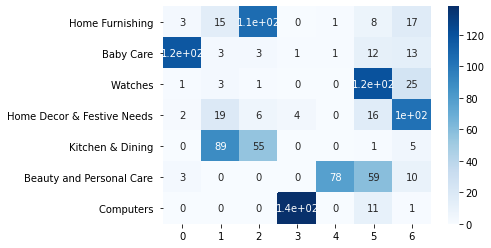

In [105]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")